In [70]:
pwd()

"/data3/yasu/capsid/docking_pairwise/3r0r_zdock_iter"

In [71]:
using Printf, DelimitedFiles
using Plots
using DataFrames
using Revise, MDToolbox
using Statistics

In [72]:
#using BSON: @save, @load
#@load "df.bson" df

In [73]:
using JLD2

df = load("df.jld2")["df"]

Row,fnames,score,omega,phi,prou,d,struc
,Any,Any,Any,Any,Any,Any,Any
1,1/complex.1.pdb,2438.18,"[-0.131239, -0.0738241, -0.988598]",176.45,"[2.287, -3.12306, -0.0703888]",0.215519,"1x3188 TrjArray{Float64, Int64}\n| 7.64 -8.73 61.51 | … 22.36 16.27 88.98 |"
2,1/complex.2.pdb,2019.56,"[0.148473, -0.0434833, 0.98796]",177.204,"[0.339791, 5.53982, 0.192761]",-0.337493,"1x3188 TrjArray{Float64, Int64}\n| 7.64 -8.73 61.51 | … 23.16 10.92 91.13 |"
3,1/complex.3.pdb,1977.51,"[-0.123651, -0.991774, 0.0330964]",130.459,"[11.0909, 0.900187, 68.4116]",6.61822,"1x3188 TrjArray{Float64, Int64}\n| 7.64 -8.73 61.51 | … -6.89 -14.94 49.86 |"
4,1/complex.4.pdb,1938.64,"[0.320035, -0.0694202, 0.944859]",176.962,"[-10.4778, 25.9029, 5.45206]",0.956278,"1x3188 TrjArray{Float64, Int64}\n| 7.64 -8.73 61.51 | … 33.01 46.83 89.06 |"
5,1/complex.5.pdb,1927.28,"[-0.0410833, 0.854917, 0.517135]",173.882,"[13.5648, -31.0287, 52.3737]",-0.322915,"1x3188 TrjArray{Float64, Int64}\n| 7.64 -8.73 61.51 | … 20.58 15.54 54.29 |"
6,1/complex.6.pdb,1892.77,"[-0.967024, 0.0406925, 0.251414]",163.8,"[19.1629, 19.823, 70.4985]",-26.9341,"1x3188 TrjArray{Float64, Int64}\n| 7.64 -8.73 61.51 | … 26.98 52.41 58.33 |"
7,1/complex.7.pdb,1860.98,"[0.993216, -0.112046, 0.0311206]",161.789,"[0.37101, 21.7032, 66.2993]",-25.3667,"1x3188 TrjArray{Float64, Int64}\n| 7.64 -8.73 61.51 | … -12.19 42.74 31.32 |"
8,1/complex.8.pdb,1854.27,"[-0.0461843, 0.940935, -0.335422]",129.447,"[10.2844, 26.0568, 71.679]",-17.4496,"1x3188 TrjArray{Float64, Int64}\n| 7.64 -8.73 61.51 | … 23.77 -27.18 90.04 |"
9,1/complex.9.pdb,1854.04,"[0.718009, -0.401641, 0.56846]",176.099,"[-24.343, 16.0746, 42.1044]",-0.486495,"1x3188 TrjArray{Float64, Int64}\n| 7.64 -8.73 61.51 | … 31.62 -9.16 59.05 |"


In [74]:
sort!(df, [:score], rev=true);
#dfs = vcat(df, df)
#sort!(dfs, [:score], rev=true)

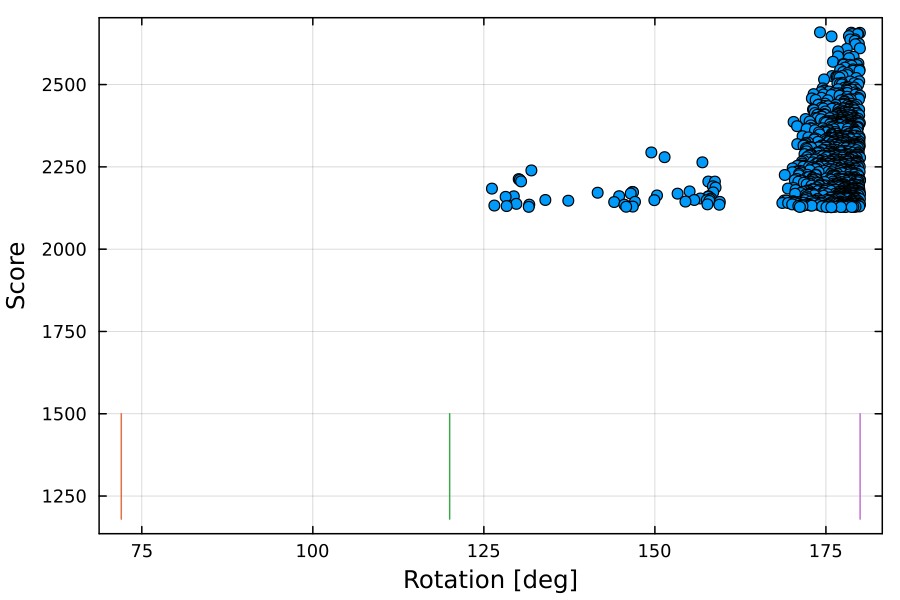

In [75]:
#pyplot()
plot(df.phi[1:1000], df.score[1:1000], seriestype=:scatter, dpi=250, label=nothing, box_style=:box)
xaxis!("Rotation [deg]"); yaxis!("Score")
#s = collect(970:1350)
s = collect(1180:1500)
plot!(fill(360/5, length(s)), s, label=nothing, dpi=250)
plot!(fill(360/3, length(s)), s, label=nothing, dpi=250)
plot!(fill(360/2, length(s)), s, label=nothing, dpi=150)

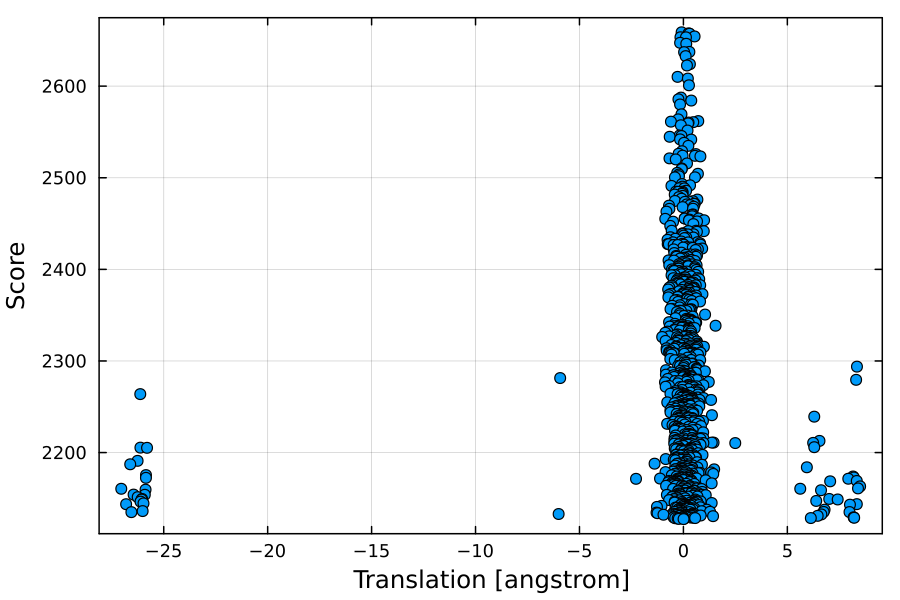

In [76]:
#pyplot()
plot(df.d[1:1000], df.score[1:1000], seriestype=:scatter, dpi=150, label=nothing, box_style=:box)
xaxis!("Translation [angstrom]"); yaxis!("Score")

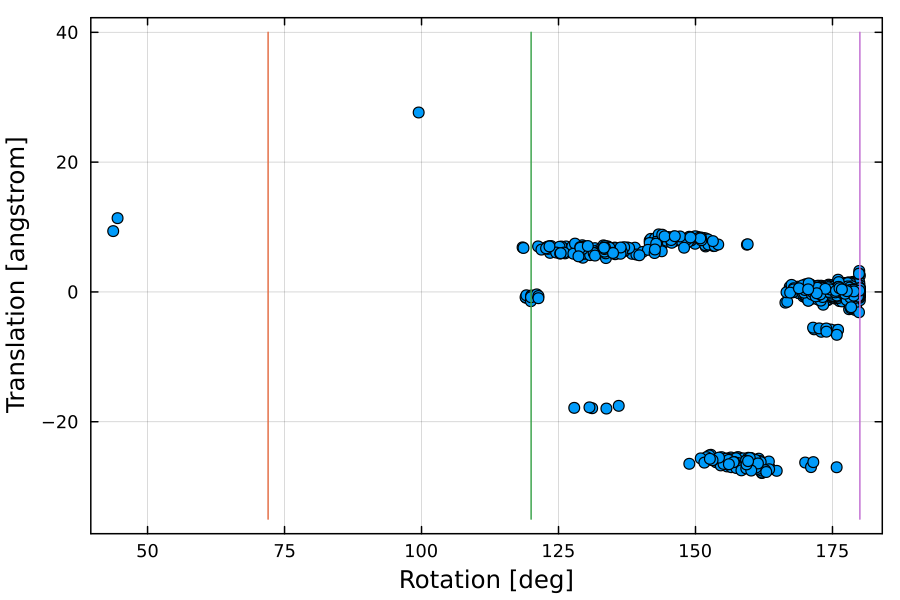

In [77]:
#pyplot()
plot(df.phi[1:2000], df.d[1:2000], seriestype=:scatter, dpi=150, label=nothing, box_style=:box)
xaxis!("Rotation [deg]"); yaxis!("Translation [angstrom]")
s = collect(-35:40)
plot!(fill(360/5, length(s)), s, label=nothing, dpi=250)
plot!(fill(360/3, length(s)), s, label=nothing, dpi=250)
plot!(fill(360/2, length(s)), s, label=nothing, dpi=150)

In [78]:
function create_heatmap(x, y, z, nx, ny)
    A = zeros(Float64, ny, nx)
    A .= -Inf64
    #edge_x = range(minimum(x), maximum(x), nx+1)
    edge_x = range(20, 185, nx+1)
    #edge_y = range(minimum(y), maximum(y), ny+1)
    edge_y = range(-40, 40, ny+1)
    for ix in 1:nx
        for iy in 1:ny
            id_x = edge_x[ix] .<= x .< edge_x[ix+1]
            id_y = edge_y[iy] .<= y .< edge_y[iy+1]
            id = id_x .& id_y
            if !isempty(z[id])
                A[iy, ix] = maximum(z[id])
            end
        end
    end
    grid_x = edge_x[1:end-1] .+ (0.5 * (edge_x[2] - edge_x[1]))
    grid_y = edge_y[1:end-1] .+ (0.5 * (edge_y[2] - edge_y[1]))
    return (z=A, x=grid_x, y=grid_y)
end

create_heatmap (generic function with 1 method)

In [79]:
function smooth_array(A, window_size)
    padded = pad_array(A, window_size)
    smoothed = similar(A)
    
    for i in 1:size(A, 1)
        for j in 1:size(A, 2)
            window = padded[i:i+window_size-1, j:j+window_size-1]
            valid_values = filter(x -> !isinf(x) && !isnan(x), window)
            smoothed[i, j] = isempty(valid_values) ? -Inf : mean(valid_values)
        end
    end
    
    return smoothed
end

function pad_array(A, window_size)
    pad_width = div(window_size - 1, 2)
    padded = fill(-Inf, size(A) .+ (2*pad_width, 2*pad_width))
    padded[pad_width+1:end-pad_width, pad_width+1:end-pad_width] = A
    return padded
end

function create_heatmap2(x, y, z, nx, ny; smooth_window=3)
    # Remove any NaN or Inf values from the input data
    valid_indices = .!isnan.(x) .& .!isinf.(x) .& .!isnan.(y) .& .!isinf.(y) .& .!isnan.(z) .& .!isinf.(z)
    x, y, z = x[valid_indices], y[valid_indices], z[valid_indices]

    # Check if there's any valid data left
    if isempty(x) || isempty(y) || isempty(z)
        error("No valid data points after removing NaN and Inf values.")
    end

    # Use the actual data range or the specified range, whichever is wider
    x_min, x_max = extrema(x)
    y_min, y_max = extrema(y)
    edge_x = range(min(20, x_min), max(185, x_max), length=nx+1)
    edge_y = range(min(-40, y_min), max(40, y_max), length=ny+1)

    A = fill(-Inf, ny, nx)
    
    for ix in 1:nx
        for iy in 1:ny
            id_x = edge_x[ix] .<= x .<= edge_x[ix+1]
            id_y = edge_y[iy] .<= y .<= edge_y[iy+1]
            id = id_x .& id_y
            if any(id)
                A[iy, ix] = maximum(z[id])
            end
        end
    end
    
    # Apply smoothing
    A_smoothed = smooth_array(A, smooth_window)
    
    grid_x = edge_x[1:end-1] .+ (0.5 * step(edge_x))
    grid_y = edge_y[1:end-1] .+ (0.5 * step(edge_y))
    
    return (z=A_smoothed, x=grid_x, y=grid_y)
end

# 使用例
# result = create_heatmap(x, y, z, 100, 80, smooth_window=5)

# using Plots
# heatmap(result.x, result.y, result.z, 
#         c=:viridis, 
#         xlabel="X", 
#         ylabel="Y", 
#         title="Smoothed Heatmap",
#         yflip=true)

create_heatmap2 (generic function with 1 method)

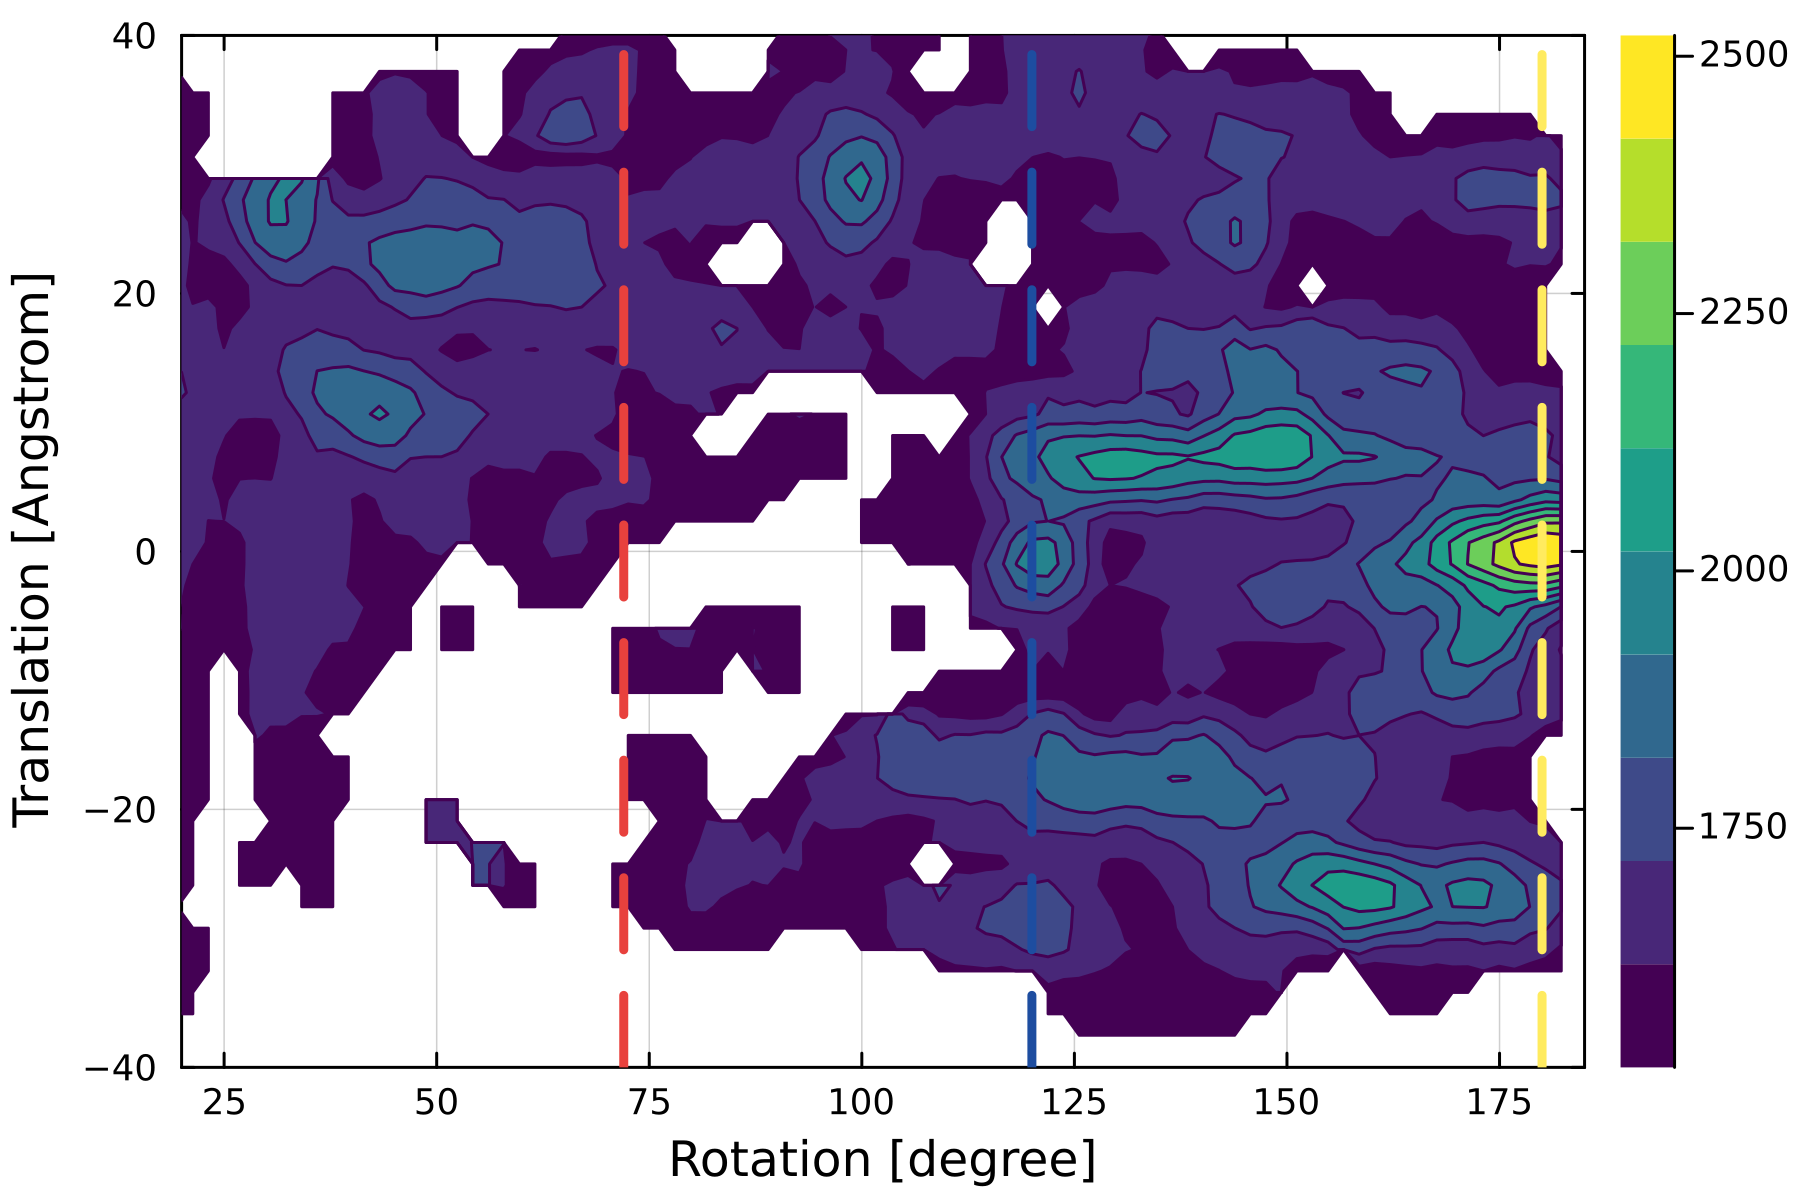

In [80]:
using Colors

n = 100000
F = create_heatmap2(df.phi[1:n], df.d[1:n], df.score[1:n], 100, 50)
p = plot(F.x, F.y, F.z, framestyle=:box, dpi=300, c=:viridis,  
     st=:contourf, levels=range(minimum(F.z[F.z .> -Inf]), maximum(F.z), 11))
     #clims=range(minimum(F.z[F.z .> -Inf]), maximum(F.z), 5))
     #color=range(minimum(F.z[F.z .> -Inf]), maximum(F.z), 100))
xlabel!("Rotation [degree]")
ylabel!("Translation [Angstrom]")

s = collect(-40:40)
plot!(fill(360/5, length(s)), s, linestyle=:dash, linewidth=3.0, linecolor=parse(Colorant, "#E8413D"), label=nothing)
plot!(fill(360/3, length(s)), s, linestyle=:dash, linewidth=3.0, linecolor=parse(Colorant, "#1D4DA0"), label=nothing)
plot!(fill(360/2, length(s)), s, linestyle=:dash, linewidth=3.0, linecolor=parse(Colorant, "#FFEB5F"), label=nothing)

xlims!((20, 185))
ylims!((-40, 40))

In [81]:
savefig(p, "heatmap_score.png")
savefig(p, "heatmap_score.pdf")

"/data3/yasu/capsid/docking_pairwise/3r0r_zdock_iter/heatmap_score.pdf"

In [82]:
function create_heatmap_min(x, y, z, nx, ny)
    A = zeros(Float64, ny, nx)
    A .= -Inf64
    #edge_x = range(minimum(x), maximum(x), nx+1)
    edge_x = range(20, 185, nx+1)
    #edge_y = range(minimum(y), maximum(y), ny+1)
    edge_y = range(-40, 40, ny+1)
    for ix in 1:nx
        for iy in 1:ny
            id_x = edge_x[ix] .<= x .< edge_x[ix+1]
            id_y = edge_y[iy] .<= y .< edge_y[iy+1]
            id = id_x .& id_y
            if !isempty(z[id])
                A[iy, ix] = minimum(z[id])
            end
        end
    end
    grid_x = edge_x[1:end-1] .+ (0.5 * (edge_x[2] - edge_x[1]))
    grid_y = edge_y[1:end-1] .+ (0.5 * (edge_y[2] - edge_y[1]))
    return (z=A, x=grid_x, y=grid_y)
end

create_heatmap_min (generic function with 1 method)

In [83]:
function create_heatmap_min2(x, y, z, nx, ny; smooth_window=3)
    # Remove any NaN or Inf values from the input data
    valid_indices = .!isnan.(x) .& .!isinf.(x) .& .!isnan.(y) .& .!isinf.(y) .& .!isnan.(z) .& .!isinf.(z)
    x, y, z = x[valid_indices], y[valid_indices], z[valid_indices]

    # Check if there's any valid data left
    if isempty(x) || isempty(y) || isempty(z)
        error("No valid data points after removing NaN and Inf values.")
    end

    # Use the actual data range or the specified range, whichever is wider
    x_min, x_max = extrema(x)
    y_min, y_max = extrema(y)
    edge_x = range(min(20, x_min), max(185, x_max), length=nx+1)
    edge_y = range(min(-40, y_min), max(40, y_max), length=ny+1)

    A = fill(Inf, ny, nx)  # Initialize with Inf for minimum calculation
    
    for ix in 1:nx
        for iy in 1:ny
            id_x = edge_x[ix] .<= x .<= edge_x[ix+1]
            id_y = edge_y[iy] .<= y .<= edge_y[iy+1]
            id = id_x .& id_y
            if any(id)
                A[iy, ix] = minimum(z[id])
            end
        end
    end
    
    # Apply smoothing
    A_smoothed = smooth_array(A, smooth_window)
    
    grid_x = edge_x[1:end-1] .+ (0.5 * step(edge_x))
    grid_y = edge_y[1:end-1] .+ (0.5 * step(edge_y))
    
    return (z=A_smoothed, x=grid_x, y=grid_y)
end

create_heatmap_min2 (generic function with 1 method)

In [84]:
using Combinatorics

function compute_rmsd_permute(ref, t, nmer)
    natom = Int(t.natom / nmer)
    nmer_ref = Int(ref.natom / natom)
    index_pairs = collect(permutations(1:nmer_ref, nmer))
    rmsd = Inf64
    for index in index_pairs
        id = Vector{Int}(undef, 0)
        for imer = 1:nmer
            id = [id; (natom*(index[imer]-1)+1):(natom * index[imer])]
        end
        ref2 = ref[:, id]
        t2 = superimpose(ref2, t)
        r = compute_rmsd(ref2, t2)
        if r[1] < rmsd
            rmsd = r[1]
        end
    end
    return rmsd
end

compute_rmsd_permute (generic function with 1 method)

In [85]:
t = mdload("ref.pdb")
t = t["atomname CA"]
ref = t[1, :]
for imer = 2:60
    ref = hcat(ref, t[imer, :])
end
ref

1x11640 TrjArray{Float64, Int64}
| A                          |  …   A                          |
| 33HIS                      |  …   226LEU                     |
| 2CA                        |  …   95161CA                    |
|     8.40    -8.94    62.77 |  …     -35.54   -68.49   -52.61 |

In [86]:
function read_ascii(fname)
    lines = readlines(fname)
    natom = length(lines) - 1
    xyz = zeros(Float64, 1, natom*3)
    for i = 1:natom
        xyz[1, 3*(i-1)+1] = parse(Float64, lines[i+1][31:38])
        xyz[1, 3*(i-1)+2] = parse(Float64, lines[i+1][39:46])
        xyz[1, 3*(i-1)+3] = parse(Float64, lines[i+1][47:54])
    end
    TrjArray(xyz=xyz)
end

read_ascii (generic function with 1 method)

In [ ]:
ntop = 10000
rmsd = zeros(Float64, ntop)
t = mdload("1/complex.1.pdb")
id = select_atom(t, "atomname CA")

for i in 1:ntop
    filename = df.fnames[i]
    t = read_ascii(filename)
    t_ca = t[:, id]
    rmsd[i] = compute_rmsd_permute(ref, t_ca, 2)
end

In [91]:
using JLD2

save("rmsd.jld2", "rmsd", rmsd, "ntop", ntop)

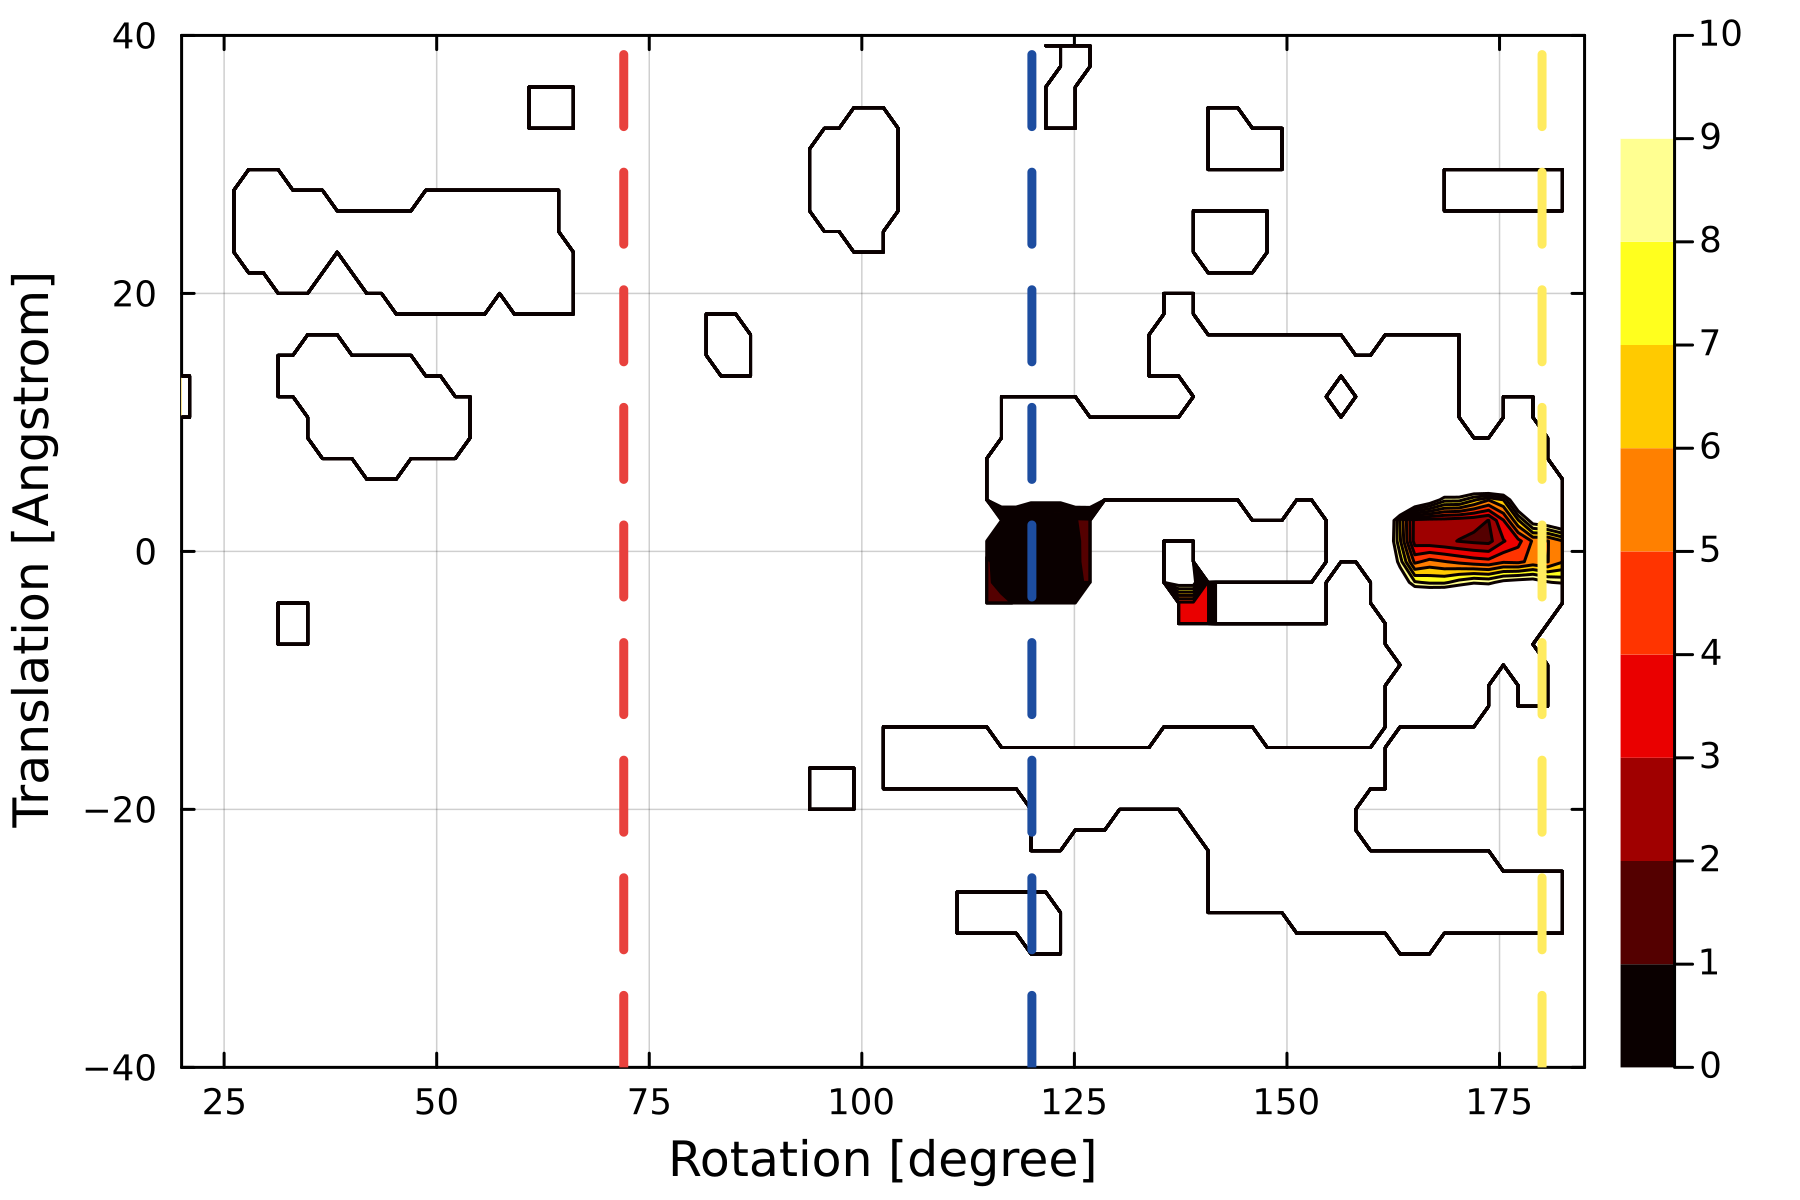

In [92]:
F = create_heatmap_min2(df.phi[1:ntop], df.d[1:ntop], rmsd[1:ntop], 100, 50)
p = plot(F.x, F.y, F.z, framestyle=:box, dpi=300, c=:hot,  
     st=:contourf, levels=range(0, 10, 11), clim=(0, 10))
xlabel!("Rotation [degree]")
ylabel!("Translation [Angstrom]")

s = collect(-40:40)
plot!(fill(360/5, length(s)), s, linestyle=:dash, linewidth=3.0, linecolor=parse(Colorant, "#E8413D"), label=nothing)
plot!(fill(360/3, length(s)), s, linestyle=:dash, linewidth=3.0, linecolor=parse(Colorant, "#1D4DA0"), label=nothing)
plot!(fill(360/2, length(s)), s, linestyle=:dash, linewidth=3.0, linecolor=parse(Colorant, "#FFEB5F"), label=nothing)

xlims!((20, 185))
ylims!((-40, 40))

In [93]:
savefig(p, "heatmap_rmsd.png")
savefig(p, "heatmap_rmsd.pdf")

"/data3/yasu/capsid/docking_pairwise/3r0r_zdock_iter/heatmap_rmsd.pdf"